In [1]:
import string
from copy import deepcopy as copy

from IPython.display import Image, clear_output, display
from Libs.Beholder import *
from PIL import Image as pilImage
from tqdm.notebook import tqdm

In [2]:
a = Beholder(videoFrameGenerator=pullPhoneScreen)

a.addLayerModifer(
    Beholder_Layer_Chopper_Grayscale(name="gray", from_layer="image", enabled=True)
)

a.addLayerModifer(
    Beholder_Layer_Chopper_AtCord(
        name="gray_letters",
        from_layer="gray",
        x=304,
        y=1632,
        w=850,
        h=860,
        enabled=True,
    )
)

In [3]:
from pathlib import Path

import requests

w = Path("words.lst")
if not w.exists():
    w.write_bytes(
        requests.get(
            "https://raw.githubusercontent.com/MariaLuo826/english_words/master/words_alpha.txt"
        ).content
    )
words = [l.upper() for l in w.read_text().splitlines()]
len(words)

370105

In [4]:
# Top words
w = Path("1ktopwords.lst")
if not w.exists():
    w.write_bytes(
        requests.get(
            "https://gist.githubusercontent.com/deekayen/4148741/raw/98d35708fa344717d8eee15d11987de6c8e26d7d/1-1000.txt"
        ).content
    )
topwords = [l.upper() for l in w.read_text().splitlines()]
len(topwords)

1000

In [5]:
# wiki words
w = Path("wikiwords.lst")
if not w.exists():
    w.write_bytes(
        requests.get(
            "https://gist.githubusercontent.com/h3xx/1976236/raw/bbabb412261386673eff521dddbe1dc815373b1d/wiki-100k.txt"
        ).content
    )
wikiwords = list(sorted(list(set([l.upper() for l in w.read_text().splitlines()]))))
len(wikiwords)

70926

In [6]:
# h3x words
w = Path("1ktopwords.lst")
if not w.exists():
    w.write_bytes(requests.get("").content)
topwords = [l.upper() for l in w.read_text().splitlines()]
len(topwords)

1000

In [7]:
a.matchers = {}
for l in string.ascii_uppercase:
    p = Path(f"./wordtrip_templates/{l}.png")
    if p.exists():
        print(f"Loading {l}")
        a.addMatcher(
            Beholder_Image_Matcher(
                name=l,
                layer="gray_letters",
                filename=str(p),
                threshhold=0.9,
            )
        )

for l in ["SH"]:
    p = Path(f"./wordtrip_templates/{l}.png")
    if p.exists():
        print(f"Loading {l}")
        a.addMatcher(
            Beholder_Image_Matcher(
                name=list(l),
                layer="gray_letters",
                filename=str(p),
                threshhold=0.9,
            )
        )

for l in ["skipvideo", "exit", "next", "close", "claim", "claim_done", "gray_x"]:
    print(f"Loading {l}")
    p = Path(f"./wordtrip_templates/{l}.png")
    a.addMatcher(
        Beholder_Image_Matcher(
            name=l,
            layer="gray",
            filename=str(p),
            threshhold=0.9,
        )
    )
"""
for l in ["white_x"]:
    print(f"Loading masked {l}")
    p = Path(f"./wordtrip_templates/{l}.png")
    a.addMatcher(
        Beholder_Image_Matcher(
            name=l,
            layer="gray",
            filename=str(p),
            mask_filename=f"./wordtrip_templates/{l}_mask.png",
            threshhold=0.9,
        )
    )"""

Loading A
Loading B
Loading C
Loading D
Loading E
Loading F
Loading G
Loading H
Loading I
Loading K
Loading L
Loading M
Loading N
Loading O
Loading P
Loading R
Loading S
Loading T
Loading U
Loading V
Loading W
Loading Y
Loading SH
Loading skipvideo
Loading exit
Loading next
Loading close
Loading claim
Loading claim_done
Loading gray_x


'\nfor l in ["white_x"]:\n    print(f"Loading masked {l}")\n    p = Path(f"./wordtrip_templates/{l}.png")\n    a.addMatcher(\n        Beholder_Image_Matcher(\n            name=l,\n            layer="gray",\n            filename=str(p),\n            mask_filename=f"./wordtrip_templates/{l}_mask.png",\n            threshhold=0.9,\n        )\n    )'

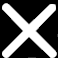

In [8]:
import cv2 as cv

templ_incl_alpha_ch = cv.imread(
    "./wordtrip_templates/white_x_mask.png", cv.IMREAD_UNCHANGED
)
display(Image.fromarray(templ_incl_alpha_ch))

In [9]:
def wordWorks(word, found_letters):
    found_letters_t = copy(found_letters)
    for letter in word:
        if letter in found_letters_t:
            found_letters_t.remove(letter)
        else:
            return False
    return True

In [10]:
def generateMoves(myword, matches):
    mymatches = copy(matches)
    moves = []
    for letter in myword:
        if letter in mymatches:
            if len(mymatches[letter]) > 0:
                m = mymatches[letter].pop(0)
                moves.append(m.center)

    return moves

In [11]:
min_len = 3
max_len = 5
eq_len = None

# Manual matcher setup 

In [12]:
matches = a.findMatches()
print(matches)
found_letters = []
for l in matches:
    for _ in range(0, len(matches[l])):
        found_letters.append(l)
print(found_letters)

matching_words = []
for word in tqdm(words):
    if len(word) < min_len or len(word) > max_len:
        continue
    if wordWorks(word, found_letters):
        matching_words.append(word)
matching_words = list(sorted(matching_words, key=len, reverse=True))
olen = 0
for word in matching_words:
    if len(word) != olen:
        print()
        olen = len(word)
    print(word, end=":")
    print(generateMoves(word, matches))

AddMatch gray_x (1328, 61)
AddMatch gray_x (1328, 63)
{'gray_x': [<Libs.Beholder.BeholderMatch object at 0x7f6978cfa1a0>, <Libs.Beholder.BeholderMatch object at 0x7f6978cf9360>]}
['gray_x', 'gray_x']


  0%|          | 0/370105 [00:00<?, ?it/s]

In [13]:
raise Exception("Stop")

Exception: Stop

# Monkey Test

In [14]:
import socket
import subprocess
import sys


class Monkey:
    def __init__(self, create_monkey=True):
        self.create_monkey = create_monkey
        self.port = 9905
        self.p = None
        self.s = None

    def __enter__(self):
        if self.p is not None:
            self.p.kill()
        adb(["forward", "--remove-all"])
        command = ["adb", "shell", "monkey", f"--port {self.port}"]
        self.p = shell(command, close_fds=True, returns_POpen=True)
        adb(f"forward tcp:{self.port} tcp:{self.port}")
        time.sleep(0.75)
        self.connect()
        return self

    def connect(self):
        HOST = "127.0.0.1"
        PORT = self.port

        if self.s is not None:
            self.s.close()
        self.s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.s.connect((HOST, PORT))

    def raw(self, s):
        try:
            self.s.sendall(f"{s}\r\n".encode("ascii"))
            # return self.s.recv(10)
        except Exception as e:
            print("raw", e)
            self.connect()
            return self.raw(s)

    def __exit__(self, exc_type, exc_value, exc_traceback):
        if self.create_monkey:
            self.p.kill()
            self.p = None
            if self.s is not None:
                self.s.close()
                self.s = None
            print("Cleaning up")
            shell(["adb", "forward", "--remove-all"])

In [ ]:
with Monkey() as monkey:
    while True:
        matches = a.findMatches()
        clicked = False
        for name in [
            "next",
            "skipvideo",
            "exit",
            "close",
            "claim",
            "claim_done",
            "white_x",
            "gray_x",
        ]:
            if name in matches:
                print(f"clicking {name}")
                c = matches[name][0].center
                adb(f"shell input tap {c[0]} {c[1]}")
                sleep(5)
                clicked = True
        if clicked:
            continue
        found_letters = []
        for l in matches:
            for _ in range(0, len(matches[l])):
                found_letters.append(l)
        print(found_letters)
        if len(found_letters) == 0:
            sleep(3)
            continue
        matching_words = []
        for word in tqdm(words):
            if len(word) < min_len or len(word) > max_len:
                continue
            if wordWorks(word, found_letters):
                matching_words.append(word)

        plen = 0
        matching_words = list(sorted(matching_words, key=len, reverse=True))
        print(matching_words)
        for word in matching_words:
            print(word)
            x = y = 0
            path = generateMoves(word, matches)
            print(path)
            isDown = False
            for x, y in path:
                if not isDown:
                    cmd = f"touch down {int(x)} {int(y)}"
                    monkey.raw(cmd)
                    isDown = True
                    time.sleep(0.5)
                    continue
                cmd = f"touch move {int(x)} {int(y)}"
                monkey.raw(cmd)
                time.sleep(0.3)
            cmd = f"touch up {int(x)} {int(y)}"
            monkey.raw(cmd)
            sleep(0.6)
        sleep(3)

  bash arg: --port
  bash arg: 9905


args: [--port, 9905]
 arg: "--port"
 arg: "9905"
arg="--port" mCurArgData="null" mNextArg=1 argwas="--port" nextarg="9905"
data="9905"


AddMatch gray_x (1328, 61)
AddMatch gray_x (1328, 63)
clicking gray_x
    // activityResuming(in.playsimple.wordtrip)


# Research


In [ ]:
raise Exception("Stop")

In [ ]:
matches = a.findMatches()
matches

In [ ]:
channels = cv2.split(a.matchers["white_x"].data)
zero_channel = np.zeros_like(channels[0])

In [ ]:
mask = np.array(channels[3])

In [ ]:
a.matchers

In [ ]:
a.matchers["white_x"].show()

In [ ]:
a.layers["gray"].show()

In [ ]:
matches["T"][0].center

In [ ]:
matches["N"][0].center

shell input touchscreen swipe x1,y1, x2,y2

https://github.com/mattwilson1024/android-pattern-unlock/blob/master/unlock.sh

In [ ]:
generateMoves("FLEET", matches)

In [ ]:
for m in matches["E"]:
    print(m, m.center)

In [ ]:
matches = a.findMatches()
found_letters = []
for l in matches:
    for _ in range(0, len(matches[l])):
        found_letters.append(l)
print(found_letters)

matching_words = []
for word in tqdm(words):
    if len(word) < min_len or len(word) > max_len:
        continue
    if wordWorks(word, found_letters):
        matching_words.append(word)

matching_words = list(sorted(matching_words, key=len, reverse=True))
matching_words

In [ ]:
def StartTouch():
    print("d")
    adb("shell -c sendevent /dev/input/event3 3 57 14")


def SendCoordinates(x, y):
    print(x, y)
    adb(f"shell -c sendevent /dev/input/event3 3 53 {x}")
    adb(f"shell -c sendevent /dev/input/event3 3 54 {y}")
    adb("shell -c sendevent /dev/input/event3 3 58 57")
    adb("shell -c endevent /dev/input/event3 0 0 0")


def FinishTouch():
    print("u")
    adb("shell sendevent /dev/input/event3 3 57 4294967295")
    adb("shell sendevent /dev/input/event3 0 0 0")

In [ ]:
plen = 0
for word in matching_words:
    print(word)
    x = y = 0
    path = generateMoves(word, matches)
    print(path)
    isDown = False
    for x, y in path:
        if not isDown:
            StartTouch()
            time.sleep(1)
            isDown = True
        SendCoordinates(int(x), int(y))
        time.sleep(0.2)
    FinishTouch()
    sleep(2)